In [13]:
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data_path = 'parsed_data_no_timestamps.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)
print(f"Shape of full dataset: {data.shape}")

X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Shape of full dataset: (2933, 90, 5)
(2346, 80, 5) (587, 80, 5) (2346, 10, 5) (587, 10, 5)


In [3]:
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps) 
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)

In [143]:
class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        pred_position = cum_disp + last_input_state.unsqueeze(1)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position
        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss # + velocity_loss + smoothness_loss # + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)

In [144]:
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-2, T_max=50)

Epoch [1/100], Training Loss: 1004.8825, LR: 0.009998
Validation Loss: 426.6399
Epoch [2/100], Training Loss: 882.4871, LR: 0.009990
Validation Loss: 454.9082
Epoch [3/100], Training Loss: 819.1121, LR: 0.009978
Validation Loss: 401.8768
Epoch [4/100], Training Loss: 749.4102, LR: 0.009961
Validation Loss: 393.1364
Epoch [5/100], Training Loss: 692.8737, LR: 0.009938
Validation Loss: 327.6217
Epoch [6/100], Training Loss: 664.0098, LR: 0.009911
Validation Loss: 300.2249
Epoch [7/100], Training Loss: 597.5158, LR: 0.009880
Validation Loss: 307.6258
Epoch [8/100], Training Loss: 510.0065, LR: 0.009843
Validation Loss: 262.4845
Epoch [9/100], Training Loss: 488.7378, LR: 0.009801
Validation Loss: 264.0234
Epoch [10/100], Training Loss: 509.0388, LR: 0.009755
Validation Loss: 256.8254
Epoch [11/100], Training Loss: 443.3612, LR: 0.009704
Validation Loss: 199.0668
Epoch [12/100], Training Loss: 401.0925, LR: 0.009649
Validation Loss: 177.9524
Epoch [13/100], Training Loss: 391.0621, LR: 0.0

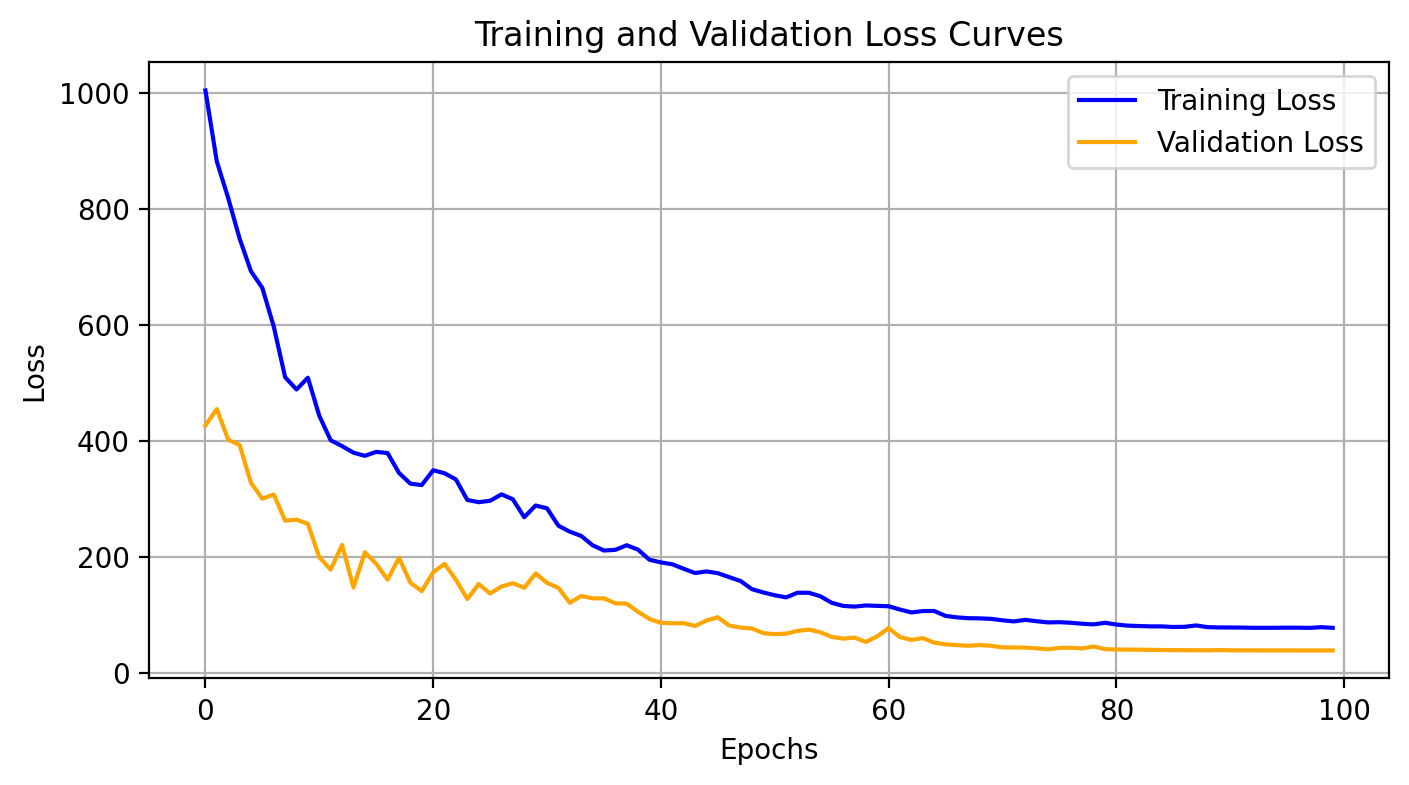

In [145]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

In [146]:
x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()

print("Mean ADE:", mean_ade)

Mean ADE: 14.73802661895752


In [132]:
# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

print(past_traj[:, :2])

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.95312500e-03  3.90625000e-03]
 [ 1.95312500e-03  9.76562500e-03]
 [ 1.95312500e-03  1.17187500e-02]
 [-6.83593750e-03 -8.78906250e-03]
 [ 1.95312500e-03  2.92968750e-03]
 [-2.92968750e-03 -7.81250000e-03]
 [-9.76562500e-04 -5.85937500e-03]
 [ 2.92968750e-03 -9.76562500e-04]
 [ 1.66015625e-02  1.56250000e-02]
 [ 2.73437500e-02  3.22265625e-02]
 [ 2.34375000e-02  2.63671875e-02]
 [ 4.39453125e-02  4.49218750e-02]
 [ 5.66406250e-02  6.25000000e-02]
 [ 6.83593750e-02  8.69140625e-02]
 [ 7.91015625e-02  1.02539062e-01]
 [ 9.96093750e-02  1.22070312e-01]
 [ 1.17187500e-01  1.50390625e-01]
 [ 1.40625000e-01  1.86523438e-01]
 [ 1.70898438e-01  2.40234375e-01]
 [ 1.97265625e-01  2.79296875e-01]
 [ 2.27539062e-01  3.30078125e-01]
 [ 2.68554688e-01  3.99414062e-01]
 [ 3.24218750e-01  4.81445312e-01]
 [ 3.99414062e-01  5.85937500e-01]
 [ 4.72656250e-01  7.24609375e-01]
 [ 5.74218750e-01  8.72070312e-01]
 [ 6.69921875e-01  1.03027344e+00]
 [ 7.80273438e-01  1

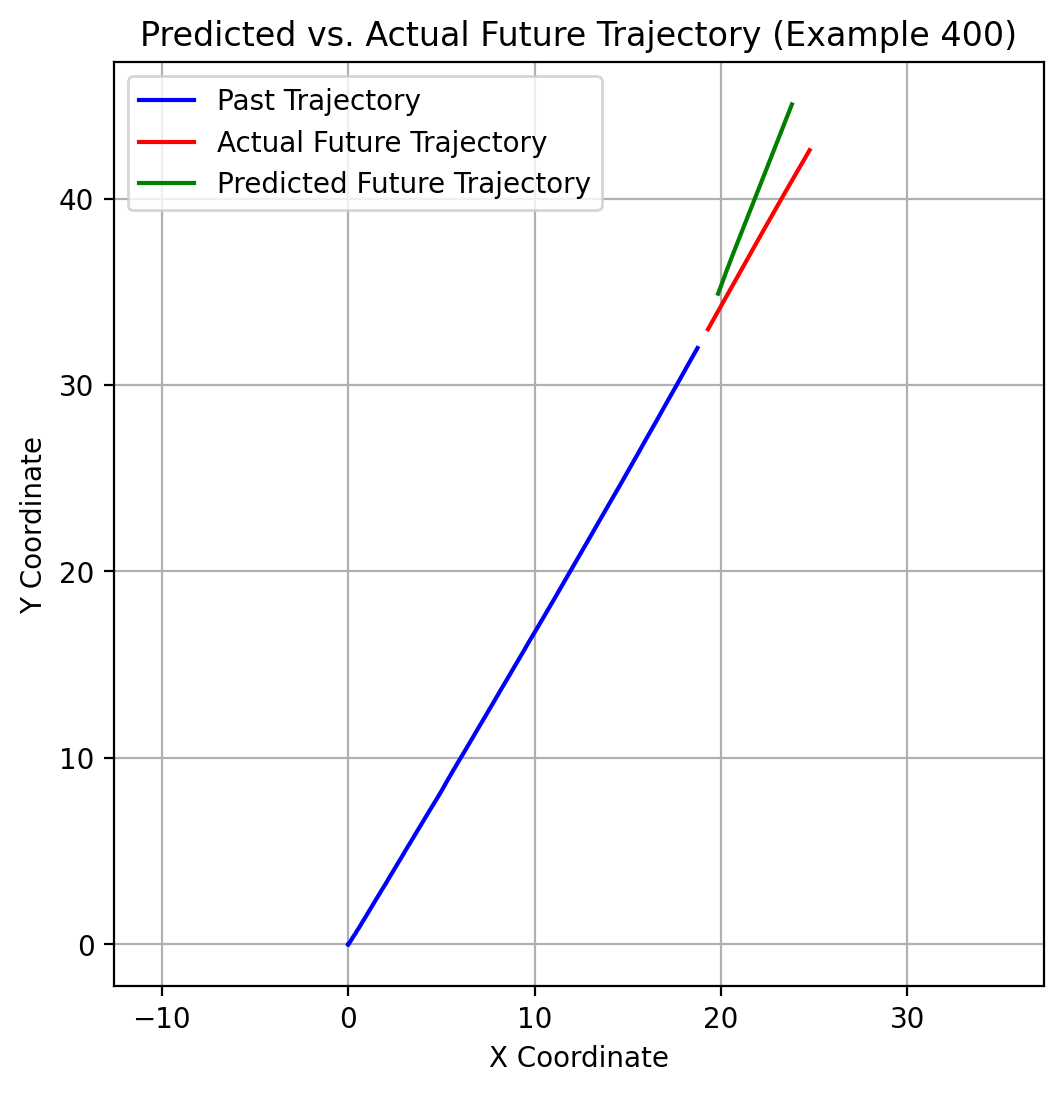

In [133]:
# Plot the past trajectory, actual future trajectory, and predicted future trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()